<a href="https://colab.research.google.com/github/mountainway184/Deraining/blob/master/U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Oct 15 03:18:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import keras
import random
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Maximum
from keras.layers import Input,DepthwiseConv2D,BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.layers import UpSampling2D, Conv2DTranspose, concatenate,DepthwiseConv2D,Add,Multiply
from keras import losses
from keras.optimizers import Adam


img_rows, img_cols, img_channels = 224, 224, 3
batch_size = 5
buffer_size = 1800
crop_size = 224

x = []
y = []

input_path = '/content/drive/My Drive/Database/Deraining/Training_data/Rain100H/Input/'
gt_path ='/content/drive/My Drive/Database/Deraining/Training_data/Rain100H/Label/'

#Load_dataset
x = np.zeros((1800,img_rows, img_cols, img_channels),dtype=np.float32) 
y = np.zeros((1800,img_rows, img_cols, img_channels),dtype=np.float32) 
for i in range(0,1800): 
  #rainy = plt.imread(input_path+'norain-%dx2.png'%(i+1))
  #label = plt.imread(gt_path+'norain-%d.png'%(i+1))
  rainy = img.imread(input_path+'norain-%dx2.png'%(i+1))
  label = img.imread(gt_path+'norain-%d.png'%(i+1))
  row = random.randint(0,rainy.shape[0] - crop_size)
  col = random.randint(0,rainy.shape[1] - crop_size)

  subim_input = rainy[row : row+crop_size, col : col+crop_size, :]#resize
  subim_label = label[row : row+crop_size, col : col+crop_size, :]
  x[i,:,:,:] = subim_input
  y[i,:,:,:] = subim_label
  print(i)

# Load dataset
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print('x.shape', x.shape)
# ('x_train.shape', (50000, 32, 32, 3))
print('y.shape', y.shape)
# ('y_train.shape', (50000, 10))

#print('x_test.shape', x_test.shape)
#print('y_test.shape', y_test.shape)

#x_train = x_train.astype('float32') / 255
#x_test = x_test.astype('float32') / 255
#x = x.astype('float32') / 255
#y = y.astype('float32') / 255
#x = x/255
#y = y/255

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1.0
0.07450981
x.shape (1800, 224, 224, 3)


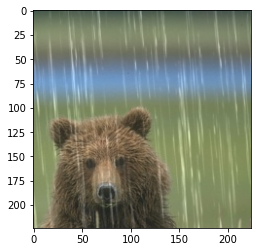

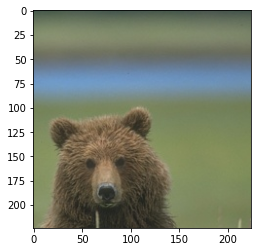

In [ ]:
#x = x/255
#y = y/255

print(np.max(x[1,:,:,:]))
print(np.min(x[1,:,:,:]))
print('x.shape', x.shape)
plt.figure()
plt.imshow(x[1,:,:,:])
plt.figure()
plt.imshow(y[1,:,:,:])

In [ ]:
#x_val = x_test[:7000]#分割
#x_test = x_test[7000:]
x_train = x[:1600]#分割
x_val = x[1600:]

y_train = y[:1600]
y_val = y[1600:]

In [ ]:
def read_data(input_path, gt_path,input_files, gt_files, size_input, num_channel, batch_size):
    Data  = np.zeros((batch_size, size_input, size_input, num_channel),dtype=np.float32) 
    Label = np.zeros((batch_size, size_input, size_input, num_channel),dtype=np.float32) 
  
    for i in range(batch_size):
  
        r_idx = random.randint(0,len(input_files)-1)
        input_file=gt_files[r_idx][:-4]+"x2.png" 

        rainy = img.imread(input_path + input_file)           
        label = img.imread(gt_path + gt_files[r_idx])

        x = random.randint(0,rainy.shape[0] - size_input)
        y = random.randint(0,rainy.shape[1] - size_input)

        subim_input = rainy[x : x+size_input, y : y+size_input, :]#resize
        subim_label = label[x : x+size_input, y : y+size_input, :]

        subim_input = subim_input*2.0-1.0#normalize
        subim_label = subim_label*2.0-1.0

        Data[i,:,:,:] = subim_input
        Label[i,:,:,:] = subim_label

    return Data, Label

In [ ]:
def FReLU(inputs,num_channels):
  x = DepthwiseConv2D(kernel_size=3, strides=1, padding='same')(inputs)
  return K.maximum(x,inputs)

#def Generator(input_size = (batch_size,None,None,img_channels)):
def Generator(input_size = (None,None,None,img_channels)):
    inputs = Input(batch_shape = (None,None,None,img_channels))

    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    conv1 = FReLU(conv1,64)
    conv1 = Conv2D(64, (3, 3), padding='same')(conv1)
    conv1 = FReLU(conv1,64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3),padding='same')(pool1)
    conv2 = FReLU(conv2,128)
    conv2 = Conv2D(128, (3, 3),padding='same')(conv2)
    conv2 = FReLU(conv2,128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3),padding='same')(pool2)
    conv3 = FReLU(conv3,256)
    conv3 = Conv2D(256, (3, 3),padding='same')(conv3)
    conv3 = FReLU(conv3,256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3),padding='same')(pool3)
    conv4 = FReLU(conv4,512)
    conv4 = Conv2D(512, (3, 3),padding='same')(conv4)
    conv4 = FReLU(conv4,512)

    up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
    up5 = FReLU(up5,256)
    up5 = concatenate([up5, conv3], axis=3)
    
    conv6 = Conv2D(256, (3, 3), padding='same')(up5)
    conv6 = FReLU(conv6,256)
    conv6 = Conv2D(256, (3, 3),padding='same')(conv6)
    conv6 = FReLU(conv6,256)

    up7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = FReLU(up7,128)
    up7 = concatenate([up7, conv2], axis=3) 

    conv8 = Conv2D(128, (3, 3), padding='same')(up7)
    conv8 = FReLU(conv8,128)
    conv8 = Conv2D(128, (3, 3),padding='same')(conv8)
    conv8 = FReLU(conv8,128)       

    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = FReLU(up9,64)
    up9 = concatenate([up9, conv1], axis=3)     

    conv10 = Conv2D(64, (3, 3), padding='same')(up9)
    conv10 = FReLU(conv10,64)
    conv10 = Conv2D(64, (3, 3),padding='same')(conv10)
    conv10 = FReLU(conv10,64)     

    conv11 = Conv2D(3,(3, 3),activation = 'sigmoid', padding='same')(conv10)
    #conv11 = Conv2D(3,(3, 3),padding='same')(conv10)
    #conv11 = FReLU(conv,3)

    model = Model(inputs=[inputs], outputs=[conv11])
    return model

In [ ]:
#from skimage.measure import compare_psnr,compare_ssim
#metrics定義
import tensorflow as tf
def psnr(y_true,y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2))/np.log(10)

def ssim(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
model = Generator()
#model.compile(optimizer='adam',loss=losses.mean_absolute_error,metrics=[psnr])
model.compile(optimizer=Adam(lr=2e-4,beta_1=0.5),loss=losses.mean_absolute_error,metrics=[psnr,ssim])
#Earlystoppingを後で挟む予定

history = model.fit(x_train,y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_val,y_val)
                    )
#history = train_on_batch()
#callbackは学習の経過を表示する

Epoch 1/30
320/320 [==============================] - 234s 731ms/step - loss: 0.1220 - psnr: 16.3900 - ssim: 0.4722 - val_loss: 0.0890 - val_psnr: 18.3821 - val_ssim: 0.5564
Epoch 2/30
320/320 [==============================] - 236s 738ms/step - loss: 0.0845 - psnr: 18.9601 - ssim: 0.6107 - val_loss: 0.0716 - val_psnr: 20.1348 - val_ssim: 0.6496
Epoch 3/30
320/320 [==============================] - 240s 750ms/step - loss: 0.0731 - psnr: 20.0971 - ssim: 0.6650 - val_loss: 0.0648 - val_psnr: 20.8550 - val_ssim: 0.6825
Epoch 4/30
320/320 [==============================] - 249s 779ms/step - loss: 0.0665 - psnr: 20.7887 - ssim: 0.6939 - val_loss: 0.0684 - val_psnr: 20.5404 - val_ssim: 0.6936
Epoch 5/30
320/320 [==============================] - 251s 784ms/step - loss: 0.0616 - psnr: 21.3702 - ssim: 0.7130 - val_loss: 0.0581 - val_psnr: 21.5548 - val_ssim: 0.7169
Epoch 6/30
320/320 [==============================] - 254s 795ms/step - loss: 0.0597 - psnr: 21.6297 - ssim: 0.7245 - val_loss: 0.

In [ ]:
model_09 = Generator()
#model.compile(optimizer='adam',loss=losses.mean_absolute_error,metrics=[psnr])
model_09.compile(optimizer=Adam(lr=2e-4,beta_1=0.9),loss=losses.mean_absolute_error,metrics=[psnr,ssim])

history_09 = model_09.fit(x_train,y_train,
                    batch_size=batch_size,
                    epochs=30,
                    verbose=1,
                    validation_data=(x_val,y_val)
                    )

Epoch 1/30
320/320 [==============================] - 234s 731ms/step - loss: 0.1236 - psnr: 16.3005 - ssim: 0.4547 - val_loss: 0.0920 - val_psnr: 18.2941 - val_ssim: 0.5423
Epoch 2/30
320/320 [==============================] - 236s 738ms/step - loss: 0.0875 - psnr: 18.6624 - ssim: 0.5914 - val_loss: 0.0798 - val_psnr: 19.3443 - val_ssim: 0.6280
Epoch 3/30
320/320 [==============================] - 238s 745ms/step - loss: 0.0747 - psnr: 19.8348 - ssim: 0.6504 - val_loss: 0.0671 - val_psnr: 20.4193 - val_ssim: 0.6697
Epoch 4/30
320/320 [==============================] - 235s 734ms/step - loss: 0.0652 - psnr: 20.8640 - ssim: 0.6868 - val_loss: 0.0608 - val_psnr: 21.3585 - val_ssim: 0.6988
Epoch 5/30
320/320 [==============================] - 235s 734ms/step - loss: 0.0621 - psnr: 21.2457 - ssim: 0.7056 - val_loss: 0.0621 - val_psnr: 21.0982 - val_ssim: 0.7017
Epoch 6/30
320/320 [==============================] - 234s 733ms/step - loss: 0.0579 - psnr: 21.8123 - ssim: 0.7242 - val_loss: 0.

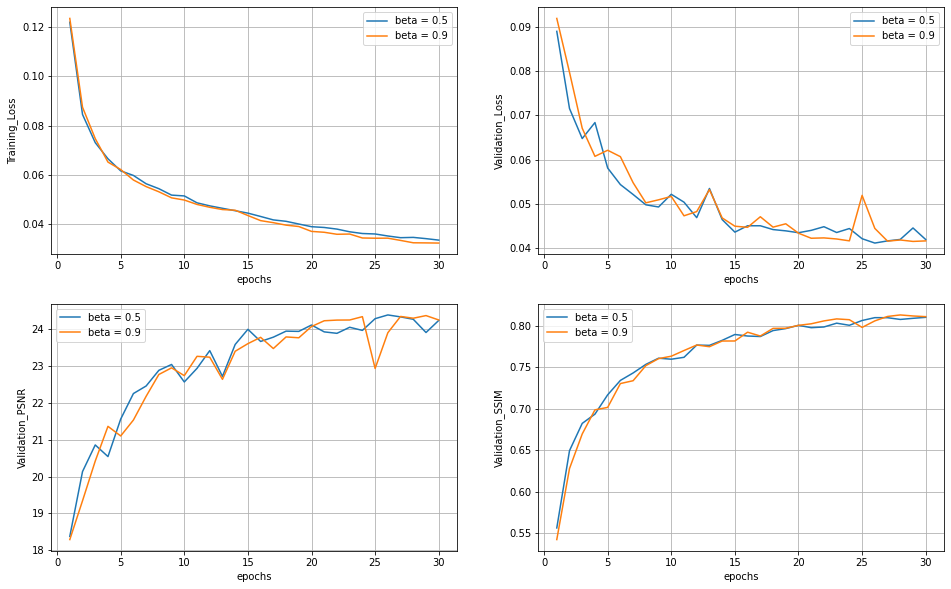

In [ ]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2,2,1,xlabel='epochs',ylabel='Training_Loss')
ax2 = fig.add_subplot(2,2,2,xlabel='epochs',ylabel='Validation_Loss')
ax3 = fig.add_subplot(2,2,3,xlabel='epochs',ylabel='Validation_PSNR')
ax4 = fig.add_subplot(2,2,4,xlabel='epochs',ylabel='Validation_SSIM')

ax1.grid()
ax1.plot(np.arange(1, len(history.history['loss'])+1),
         history.history['loss'], label='beta = 0.5')
ax1.plot(np.arange(1, len(history_09.history['loss'])+1),
         history_09.history['loss'], label='beta = 0.9')
ax1.legend()

ax2.grid()
ax2.plot(np.arange(1, len(history.history['loss'])+1),
         history.history['val_loss'], label='beta = 0.5')
ax2.plot(np.arange(1, len(history_09.history['loss'])+1),
         history_09.history['val_loss'], label='beta = 0.9')
ax2.legend()

ax3.grid()
ax3.plot(np.arange(1, len(history.history['val_psnr'])+1),
         history.history['val_psnr'], label='beta = 0.5')
ax3.plot(np.arange(1, len(history_09.history['val_psnr'])+1),
         history_09.history['val_psnr'], label='beta = 0.9')
ax3.legend()

ax4.grid()
ax4.plot(np.arange(1, len(history.history['val_ssim'])+1),
         history.history['val_ssim'], label='beta = 0.5')
ax4.plot(np.arange(1, len(history_09.history['val_ssim'])+1),
         history_09.history['val_ssim'], label='beta = 0.9')
ax4.legend()



In [ ]:
#test = model.predict(x_test)#テストデータを用意
test_val = model.predict(x_val)

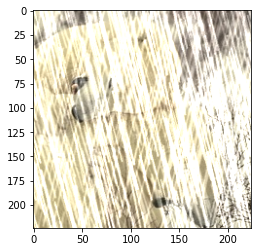

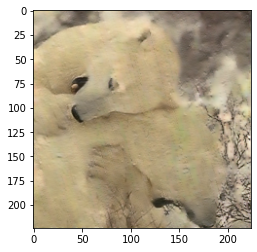

In [ ]:
plt.figure()
plt.imshow(x_val[1,:,:,:])
plt.figure()
plt.imshow(test_val[1,:,:,:])

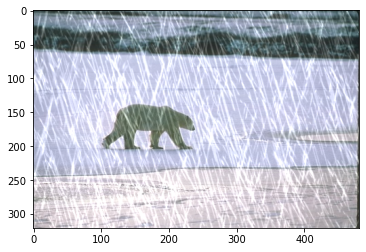

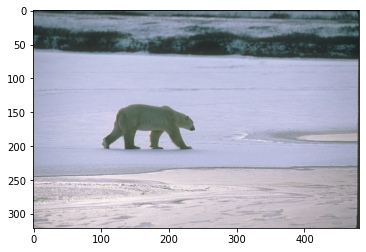

In [ ]:
test_input_path = '/content/drive/My Drive/Database/Deraining/Test_data/Rain100H/X2/'
test_gt_path ='/content/drive/My Drive/Database/Deraining/Test_data/Rain100H/Label/'

x_test = []
y_test = []

for i in range(0,200): 
  xtest = img.imread(test_input_path+'norain-%d.png'%(i+1))
  ytest = img.imread(test_gt_path+'norain-%d.png'%(i+1))
  x_test.append(xtest)
  y_test.append(ytest)
x_test = np.array(x_test)
y_test = np.array(y_test)

plt.figure()
plt.imshow(x_test[0])
plt.figure()
plt.imshow(y_test[0])

In [ ]:
test = []
for i in range(200):
  if (x_test[i].shape[0]%2) == 1:
    x_test[i] = x_test[i][:-1,:,:]
  if (x_test[i].shape[1]%2) == 1:
    x_test[i] = x_test[i][:,:-1,:]

test = model.predict(x_test)


ValueError: ignored

In [ ]:
json_string = model.to_json()

In [ ]:
model.save_weights('param.hdf5')

model.load_weights('param.hdf5')